<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_jaxFlax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Standard libraries
import os
import glob
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy
from google.colab import drive
import time





## Imports for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
%matplotlib inline
#from IPython.display import set_matplotlib_formats
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map


## Flax
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax




In [2]:
# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*csv')

print(len(cvs_names))
#cvs_names_v2 = glob.glob(os.path.join(path, '*csv'))
#cvs_names==cvs_names_v2

# Extract and print the names of the files without suffix
files_names=[]
for names in cvs_names:
    names_without_suffix = os.path.splitext(os.path.basename(names))[0]
    #print(names_without_suffix)
    files_names.append(names_without_suffix)

996


In [5]:
angles_list     = []
banks_list      = []
weights_list    = []
exactStates_list = []
for  name in tqdm(files_names):
    try:
        data        = np.loadtxt(os.path.join(path, f'{name}.csv'), delimiter=',', skiprows=1)
        bank        = np.load(os.path.join(path, f'{name}_reward_bank.npy'), mmap_mode="r")
        weights     = np.load(os.path.join(path, f'{name}_reward_weights.npy'), mmap_mode="r")
        exactStates = np.load(os.path.join(path, f'{name}_reward_extra_data.npy'), mmap_mode="r")

        angles_list.append(data)
        banks_list.append(bank[1:])
        weights_list.append(weights[1:])
        exactStates_list.append(exactStates)
    except Exception as e:
        print(f"Error loading data for file {name}: {e}")


  0%|          | 0/996 [00:00<?, ?it/s]

In [6]:
angles_data      = np.stack(angles_list)
banks_data       = np.stack(banks_list)
weights_data     = np.stack(weights_list)
exactStates_data = np.stack(exactStates_list)

# Generate new data with shape (1000, 100, 2)
new_data = np.zeros((angles_data.shape[0], angles_data.shape[1], 2))
new_data[...,0] = np.sin(angles_data[:,:,0])
new_data[...,1] = np.sin(angles_data[:,:,1])


angles_data = np.insert(angles_data, [3, 4], new_data, axis=-1)



print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)
print(exactStates_data.shape)

(996, 99, 7)
(996, 99, 100, 2, 2)
(996, 99, 100)
(996, 2)


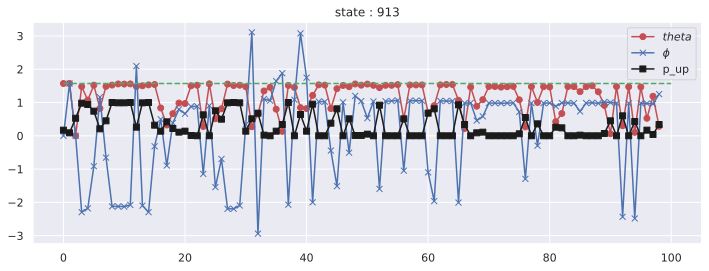

In [7]:
state= np.random.randint(angles_data.shape[0])
plt.figure(figsize=(12,4))
plt.plot(angles_data[state,:,0],'o-r',label=r'$theta$')
plt.plot(angles_data[state,:,1],'x-b',label=r'$\phi$')
plt.plot(angles_data[state,:,2],'s-k',label='p_up')
plt.hlines(y=np.pi/2, xmin=0, xmax=100, linestyles='--',color='g')
plt.title(f'state : {state}')
plt.legend()
plt.show()

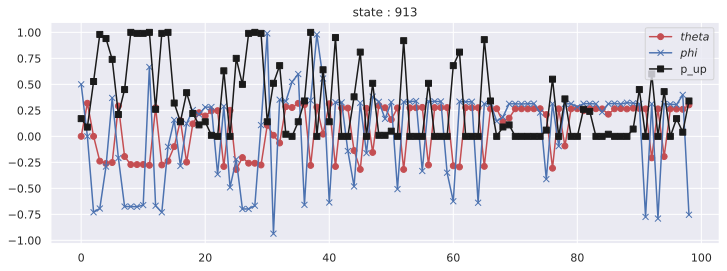

In [8]:
plt.figure(figsize=(12,4))
plt.plot(angles_data[state,:,5]/np.pi,'o-r',label=r'$theta$')
plt.plot(angles_data[state,:,6]/np.pi,'x-b',label=r'$phi$')
plt.plot(angles_data[state,:,2],'s-k',label='p_up')
plt.title(f'state : {state}')
plt.legend()
plt.show()

In [9]:
predic_index  = 20
angles_input  = jnp.array(angles_data[:,:predic_index,:5])
angles_target = jnp.array(angles_data[:, predic_index,5:])
banks         = jnp.array(banks_data[:,predic_index,...])
weights       = jnp.array(weights_data[:,predic_index,:])

print(angles_input.shape)
print(angles_target.shape)
print(banks.shape)
print(weights.shape)

(996, 20, 5)
(996, 2)
(996, 100, 2, 2)
(996, 100)


In [10]:
# Set the percentage of data to use for validation
validation_split = 0.2

# Determine the number of samples to use for validation
num_validation_samples = int(angles_input.shape[0] * validation_split)

# Split the data into training and validation sets
train_angles_input  = angles_input[:-num_validation_samples]
train_angles_target = angles_target[:-num_validation_samples]
train_banks         = banks[:-num_validation_samples]
train_weights       = weights[:-num_validation_samples]


valid_angles_input  = angles_input[-num_validation_samples:]
valid_angles_target = angles_target[-num_validation_samples:]
valid_banks         = banks[-num_validation_samples:]
valid_weights       = weights[-num_validation_samples:]


data_train = (train_angles_input, train_angles_target, train_banks, train_weights)
data_valid = (valid_angles_input, valid_angles_target, valid_banks, valid_weights)

In [11]:
# Create a JAX data loader
def data_loader(data, batch_size):
    angles_input, angles_target, banks, weights = data
    num_samples = angles_input.shape[0]
    num_batches = num_samples // batch_size

    def batch_iter():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            yield angles_input[start_idx:end_idx], angles_target[start_idx:end_idx], banks[start_idx:end_idx], weights[start_idx:end_idx]

    return batch_iter()

In [14]:
class InfoGain():
    def __init__(self):
        pass

    def information_gain(self, angles, banks, weights):

        if not jnp.iscomplexobj(banks):
           raise ValueError("The 'banks' array must be of complex data type.")

        best_guess = jnp.einsum('ijkl,ij->ikl', banks, weights)
        return self.adaptive_cost_func(angles, banks, weights, best_guess)

    def adaptive_cost_func(self, angles, rhoBank, weights, bestGuess):
        # Creates projector from angles
        povm = self.angles_to_single_qubit_POVM(angles)
        # Computes the entropy of prior and posterior distributions.
        K = self.Shannon_entropy(jnp.einsum('nijk,nkj->ni', povm, bestGuess))
        J = self.Shannon_entropy(jnp.einsum('nijk,nlkj->nil', povm, rhoBank))
        # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
        return jnp.real(K - jnp.einsum("ij,ij->i", J, weights))

    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob = jnp.maximum(prob, epsilon)  # Replace zeros with epsilon
        return jnp.real(jnp.sum(-(prob * jnp.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):

        up_state_vector = jnp.array([jnp.cos(angles[:, 0] / 2), jnp.exp(1j * angles[:, 1]) * jnp.sin(angles[:, 0] / 2)],
                                    dtype=complex)
        up_POVM = jnp.einsum("in,jn->nij", up_state_vector, up_state_vector.conj())
        return jnp.einsum('injk->nijk', jnp.array([up_POVM[:], jnp.eye(2) - up_POVM[:]], dtype=complex))


info_gain = InfoGain()

In [15]:
@jax.jit
def mse(y_true, y_pred):
     #mean over batch
    return jnp.mean(jnp.square(y_true - y_pred))

In [16]:
@jax.jit
def custom_loss(y_true, y_pred, banks, weights, choice=4, lambda_weight=0.0):
    true_info_gains = info_gain.information_gain(y_true, banks, weights)
    pred_info_gains = info_gain.information_gain(y_pred, banks, weights)

    true_info_gains *=1e4
    pred_info_gains *=1e4

    if choice == 1:
        loss_infoGain = jnp.abs(pred_info_gains - true_info_gains)
    elif choice == 2:
        loss_infoGain = 1.0 * jnp.abs(1.0 - pred_info_gains / true_info_gains)
    elif choice == 3:
        loss_infoGain =  -1.0 * jnp.square(true_info_gains**2 - pred_info_gains**2)
    elif choice == 4:
        loss_infoGain = -1.0 * pred_info_gains
    elif choice == 5:
        loss_infoGain = (true_info_gains - pred_info_gains)
    else:
        raise ValueError("Invalid choice value. Please choose 1, 2, 3, 4 or 5.")



    ## mean  over batch
    loss_infoGain = jnp.mean(loss_infoGain)


    true_info_gains, pred_info_gains = jnp.mean(true_info_gains), jnp.mean(pred_info_gains)

    return ((1.0 - lambda_weight) * loss_infoGain + lambda_weight * mse(y_true, y_pred), [true_info_gains, pred_info_gains])


In [17]:
class GATLayer(nn.Module):
    features : int  # features F'
    N        : int  # number of nodes

    def setup(self):
        self.W = nn.Dense(features=self.features, kernel_init=nn.initializers.glorot_uniform(),use_bias=False)
        self.a = nn.Dense(features=1,kernel_init=nn.initializers.glorot_uniform(),use_bias=False)


    def attention(self, x):
        batch_size, N, F = x.shape
        alpha = jnp.empty((batch_size, N, N))
        for i in range(N):
            for j in range(N):
                e_ij  = self.a(jnp.concatenate((x[:,i,:], x[:,j,:]), -1))
                e_ij = jax.nn.leaky_relu(e_ij, negative_slope=0.2)
                alpha = alpha.at[:,i,j].set(e_ij.flatten())
        return alpha


    def attention_vec(self,x):
        batch_size, N, F = x.shape

        # Repeat x to create (batch_size, N, N, F) tensor
        x_i = jnp.expand_dims(x, axis=2)  # (batch_size, N, 1, F)
        x_j = jnp.expand_dims(x, axis=1)  # (batch_size, 1, N, F)
        x_ij = jnp.concatenate((x_i, x_j), axis=-1)  # (batch_size, N, N, 2F)

        # Apply the attention mechanism to the concatenated tensor
        e_ij = self.a(x_ij)
        e_ij = jax.nn.leaky_relu(e_ij, negative_slope=0.2)

        # Flatten the result and reshape to get the attention matrix
        alpha = jnp.reshape(e_ij, (batch_size, N, N))

        return alpha


    def __call__(self, x):
          adj_matrix = jnp.ones((x.shape[0], self.N,self.N)) # all to all connections
          x = self.W(x)
          # applying self-attention
          alpha_ij = self.attention(x)
          # masking based on "adj_matrix"
          #alpha_ij = jnp.where(adj_matrix == 1., alpha_ij, jnp.ones_like(alpha_ij) * (-9e15))
          # apply nonlinearity
          alpha_ij = nn.softmax(alpha_ij, axis=-1)
          # weighted sum
          h = jnp.einsum("bij,bjl->bil", alpha_ij, x)
          return h


class GATLayerMultilayer(nn.Module):
    heads: int
    hidden:int
    nodes: int

    def setup(self):
        self.gat_layers = [GATLayer(features=self.hidden, N=self.nodes) for _ in range(self.heads)]

    def __call__(self, x):
        gta_list = [gat_layer(x) for gat_layer in self.gat_layers]
        # staking all gat layesrs, creat new tensor on axis=0,
        gta_array = jnp.stack(gta_list)
        # average over all attention layers, on the axis=0
        mean_result = jnp.mean(gta_array, axis=0)
        return nn.sigmoid(mean_result) #???


class NN(nn.Module):
    features: int
    def setup(self):
        self.W = nn.Dense(self.features)
    def __call__(self, x):
        return self.W(x)


class MainModel(nn.Module):
    latent_features: int
    gta_features: int
    final_features: int
    heads: int
    nodes: int


    def setup(self):
        self.dense1 = nn.Dense(self.latent_features)
        self.gat    = GATLayerMultilayer(self.heads, self.gta_features, self.nodes)
        self.dense2 = nn.Dense(64)
        self.dense3 = nn.Dense(32)
        self.dense4 = nn.Dense(self.final_features)

    def __call__(self, x):
        x = nn.relu(self.dense1(x)) # (batch_size=32, nodes=50, features=3) --> (batch_size, nodes=50, latent_features=8)
        x = self.gat(x)
        #--- aggregation     (batch_size, nodes=50, Features)   --> (batch_size, 1 , 8)
        #x = jnp.mean(x, axis=1)
        x = nn.relu(self.dense2(x))
        x = nn.relu(self.dense3(x))
        x = jnp.reshape(x, (x.shape[0], -1))  # Flatten
        x = self.dense4(x)
        return x

In [18]:
# create the model

heads           = 1
latent_features = 8
gta_features    = 8
final_features  = 2
nodes           = predic_index
batch_size      = 64
choice          = 4

net = MainModel(latent_features=latent_features,
                      gta_features=gta_features,
                      final_features=final_features,
                      heads=heads,
                      nodes=nodes)



In [19]:
#initialize network parameters and solver state
LEARNING_RATE = 0.0001
solver        = optax.adam(LEARNING_RATE)
rng           = jax.random.PRNGKey(0)
dummy_data    = jnp.ones((batch_size, nodes, 5))
params        = net.init(rng, dummy_data)
solver_state  = solver.init(params)

In [20]:

@jax.jit
def predict(params, inputs):
  return net.apply(params, inputs)


@jax.jit
def loss_accuracy(params, data):
    """Computes loss over a batch.
    Args:
      params: parameters of the model.
      data: tuple of (angles, banks, weights).

    Returns:
      loss: float
    """
    angles_input, angles_target, banks, weights = data
    angles_predict = predict(params, angles_input)
    loss           = custom_loss(angles_target, angles_predict, banks, weights)
    return loss


In [21]:
@jax.jit
def train_step(params, solver_state, batch):
  # Performs a one step update.
  loss, grad            = jax.value_and_grad(loss_accuracy, has_aux=True)(params, batch)
  updates, solver_state = solver.update(grad, solver_state, params)
  params                = optax.apply_updates(params, updates)
  return params, solver_state, loss

# Validation function
@jax.jit
def evaluate(params, batch):
    return loss_accuracy(params, batch)


In [22]:
#train_batch = next(data_loader(train_angles_input, train_angles_target, train_banks, train_weights, batch_size))
#x,y,z,t = train_batch
#x.shape
#out = predict(params, train_batch[0])

In [23]:

N_EPOCHS     = 301
train_losses = []
valid_losses = []
train_true_Info_Gains = []
valid_pred_Info_Gains = []
train_pred_Info_Gains = []
valid_true_Info_Gains = []

for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    start_time         = time.time()  # Record start time for the epoch
    train_losses_epoch = []
    valid_losses_epoch = []

    train_true_Info_Gains_epoch = []
    valid_true_Info_Gains_epoch = []
    train_pred_Info_Gains_epoch = []
    valid_pred_Info_Gains_epoch = []

    for train_batch in data_loader(data_train, batch_size):
        params, solver_state, train_loss = train_step(params, solver_state, train_batch)
        train_losses_epoch.append(train_loss[0])
        train_true_Info_Gains_epoch.append(train_loss[1][0])
        train_pred_Info_Gains_epoch.append(train_loss[1][1])


    for valid_batch in data_loader(data_valid, batch_size):
        valid_loss = evaluate(params, valid_batch)
        valid_losses_epoch.append(valid_loss[0])
        valid_true_Info_Gains_epoch.append(valid_loss[1][0])
        valid_pred_Info_Gains_epoch.append(valid_loss[1][1])


    valid_losses.append(np.mean(valid_losses_epoch))
    train_losses.append(np.mean(train_losses_epoch))

    train_true_Info_Gains.append(np.mean(train_true_Info_Gains_epoch))
    valid_true_Info_Gains.append(np.mean(valid_true_Info_Gains_epoch))

    train_pred_Info_Gains.append(np.mean(train_pred_Info_Gains_epoch))
    valid_pred_Info_Gains.append(np.mean(valid_pred_Info_Gains_epoch))

    end_time = time.time()  # Record end time for the epoch
    epoch_time = end_time - start_time
    if epoch % 20 == 0:
        tqdm.write(f"Epoch {epoch + 1}/{N_EPOCHS}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Time: {epoch_time:.4f} seconds")


Epochs:   0%|          | 0/301 [00:00<?, ?it/s]

Epoch 1/301, Training Loss: -9.0106, Validation Loss: -9.0863, Time: 66.9336 seconds
Epoch 21/301, Training Loss: -9.0761, Validation Loss: -9.0659, Time: 0.1057 seconds
Epoch 41/301, Training Loss: -9.0868, Validation Loss: -9.0659, Time: 0.1000 seconds
Epoch 61/301, Training Loss: -9.1049, Validation Loss: -9.0650, Time: 0.1153 seconds
Epoch 81/301, Training Loss: -9.1509, Validation Loss: -9.0800, Time: 0.1433 seconds
Epoch 101/301, Training Loss: -9.1693, Validation Loss: -9.0877, Time: 0.1057 seconds
Epoch 121/301, Training Loss: -9.1708, Validation Loss: -9.0920, Time: 0.1183 seconds
Epoch 141/301, Training Loss: -9.1722, Validation Loss: -9.0963, Time: 0.1034 seconds
Epoch 161/301, Training Loss: -9.1734, Validation Loss: -9.1010, Time: 0.1066 seconds
Epoch 181/301, Training Loss: -9.1746, Validation Loss: -9.1060, Time: 0.1054 seconds
Epoch 201/301, Training Loss: -9.1757, Validation Loss: -9.1098, Time: 0.1498 seconds
Epoch 221/301, Training Loss: -9.1767, Validation Loss: -9.

In [24]:

path1 = f"/content/drive/MyDrive/SL_data/plot_training_losses_valid_losses_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}.pdf"
path2 = f"/content/drive/MyDrive/SL_data/plot_InfoGains_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}.pdf"



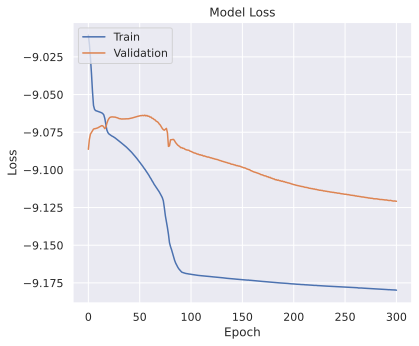

In [25]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig(path1, format='pdf')
plt.show()

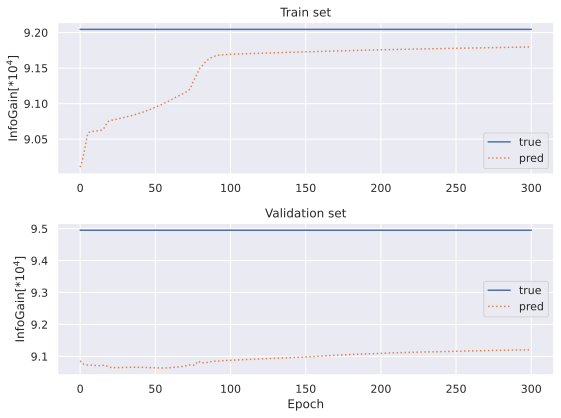

In [26]:
# Plot the training history

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.title('Train set')
plt.plot(train_true_Info_Gains,'-', label='true')
plt.plot(train_pred_Info_Gains,':', label='pred')
plt.ylabel(r'InfoGain[$*10^4$]')
plt.legend()
plt.subplot(212)
plt.title('Validation set')
plt.plot(valid_true_Info_Gains,'-', label='true')
plt.plot(valid_pred_Info_Gains,':', label='pred')
plt.ylabel(r'InfoGain[$*10^4$]')
plt.xlabel('Epoch')
plt.legend()
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(path2, format='pdf')
plt.show()

In [27]:
def save_model_params(params, save_path):
    with open(save_path, "wb") as f:
        pickle.dump(params, f)

def save_training_losses(train_losses, valid_losses, losses_path):
    with open(losses_path, "wb") as f:
        pickle.dump((train_losses, valid_losses), f)



In [28]:

save_path = f"/content/drive/MyDrive/SL_data/trained_model_params_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}.pkl"
save_model_params(params, save_path)


losses_path = f"/content/drive/MyDrive/SL_data/training_losses_valid_losses_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}.pkl"
save_training_losses(train_losses, valid_losses, losses_path)


In [29]:
true_angle = []
pred_angle = []
#data_valid = (valid_angles_input, valid_angles_target, valid_banks, valid_weights)
for valid_batch in data_loader(data_valid, batch_size):
    #print(input[0].shape)
    pred_angle.append(predict(params, valid_batch[0]))
    true_angle.append(valid_batch[1])



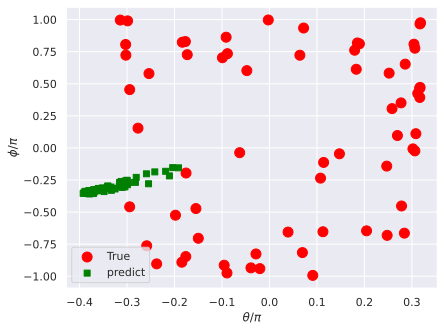

In [30]:
path3 = f"/content/drive/MyDrive/SL_data/plot_distrinution_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}.pdf"

i = np.random.randint(len(true_angle));
plt.scatter(true_angle[i][:,0]/np.pi,true_angle[i][:,1]/np.pi, color='red', s =100, marker='o', label='True');
plt.scatter(pred_angle[i][:,0]/np.pi,pred_angle[i][:,1]/np.pi, color='green', marker='s', label='predict');
plt.xlabel(r'$\theta/\pi$')
plt.ylabel(r'$\phi/\pi$')
plt.tight_layout()
#plt.savefig(path3, format='pdf')
plt.legend()

In [31]:
"""
i = np.random.randint(len(true_angle))
x_t, y_t = true_angle[i][:, 0], true_angle[i][:, 1]
x_p, y_p = pred_angle[i][:, 0], true_angle[i][:, 1]

# Create a figure with two subplots
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121, polar=True)
ax2 = plt.subplot(122)

#fig.suptitle('Coordinate Comparison', fontsize=16)

# Initialize empty lines for the animation
line1, = ax1.plot([], [])
line2, = ax2.plot([], [])


# Function to update the plots for each frame
def update(frame):
    # Update the data for the first subplot (Cartesian)

    ax1.cla()  # Clear the previous plot
    if frame!=0:
        ax1.plot(x_t[:frame-1], y_t[:frame-1], 'or', markersize=5, alpha= 0.2)
        ax1.plot(x_p[:frame-1], y_p[:frame-1], 'sg', markersize=3,  alpha= 0.2)

    ax1.plot(x_t[frame], y_t[frame], 'ob', markersize=10, label='True Angle')
    ax1.plot(x_p[frame], y_p[frame], 'sk', markersize=6, label='Predicted Angle')


    ax2.cla()  # Clear the previous polar plot
    if frame!=0:
        ax2.plot(x_t[:frame-1], y_t[:frame-1], 'or', markersize=5, alpha= 0.2)
        ax2.plot(x_p[:frame-1], y_p[:frame-1], 'sg', markersize=3, alpha= 0.2)

    ax2.plot(x_t[frame], y_t[frame], 'ob', markersize=10,  label='True Angle')
    ax2.plot(x_p[frame], y_p[frame], 'sk', markersize=6, label='Predicted Angle')

    ax1.legend(fontsize='small', loc='upper right')
    ax2.legend(fontsize='small', loc='upper right')



# Create an animation
animation_interval = 1000  # Interval between frames in milliseconds
ani = FuncAnimation(fig, update, frames=len(x_t), repeat=False, interval=animation_interval)



# Display the animation using HTML
display(HTML(ani.to_jshtml()))


# To save the animation as an HTML file, you can use ani.save('animation.html', writer='html')
#save_path = f"/content/drive/MyDrive/SL_data/animation_LEARNING_RATE{LEARNING_RATE}_predic_index{predic_index}_validation_split{validation_split}.html"
save_path = 'animation.html'
ani.save(save_path, writer='html')
"""


'\ni = np.random.randint(len(true_angle))\nx_t, y_t = true_angle[i][:, 0], true_angle[i][:, 1]\nx_p, y_p = pred_angle[i][:, 0], true_angle[i][:, 1]\n\n# Create a figure with two subplots\nfig = plt.figure(figsize=(12, 5))\nax1 = plt.subplot(121, polar=True)\nax2 = plt.subplot(122)\n\n#fig.suptitle(\'Coordinate Comparison\', fontsize=16)\n\n# Initialize empty lines for the animation\nline1, = ax1.plot([], [])\nline2, = ax2.plot([], [])\n\n\n# Function to update the plots for each frame\ndef update(frame):\n    # Update the data for the first subplot (Cartesian)\n\n    ax1.cla()  # Clear the previous plot\n    if frame!=0:\n        ax1.plot(x_t[:frame-1], y_t[:frame-1], \'or\', markersize=5, alpha= 0.2)\n        ax1.plot(x_p[:frame-1], y_p[:frame-1], \'sg\', markersize=3,  alpha= 0.2)\n\n    ax1.plot(x_t[frame], y_t[frame], \'ob\', markersize=10, label=\'True Angle\')\n    ax1.plot(x_p[frame], y_p[frame], \'sk\', markersize=6, label=\'Predicted Angle\')\n\n\n    ax2.cla()  # Clear the pr

In [32]:
def myPlot(theta,phi,result,true_angle,pred_angle,exactStates, scaled):
   # Plot the 3D surface plot
    fig = plt.figure(figsize=(12, 4))

    # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.3)

    # 3D Plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(theta/np.pi, phi/np.pi, result, cmap='gist_rainbow', edgecolor='none')
    ax1.set_xlabel(r'$\theta/\pi$')
    ax1.set_ylabel(r'$\phi/\pi$')

    #ax1.set_zlabel('Normalized Information Gain')


    # 2D Plot
    ax2 = fig.add_subplot(122)
    c = ax2.contourf(theta/np.pi, phi/np.pi, result, cmap='gist_rainbow', levels=np.linspace(np.min(result), np.max(result), 51))
    contour = ax2.contour(theta/np.pi, phi/np.pi, result, colors='black', linewidths=0.5)
    #ax2.clabel(contour, inline=True, fontsize=8, colors='w', fmt='%1.2f')

    ax2.scatter(true_angle[0]/np.pi, true_angle[1]/np.pi, color='k', marker='*', s=300)
    ax2.scatter(pred_angle[0][0]/np.pi, pred_angle[0][1]/np.pi, color='w', marker='X', s=300)
    ax2.scatter(exactStates[0]/np.pi, exactStates[1]/np.pi, color='r', marker='x', s=400)




    ax2.set_xlabel(r'$\theta/\pi$')
    ax2.set_ylabel(r'$\phi/\pi$')
    fig.colorbar(c)


    # Add a common title for the entire figure
    fig.suptitle(f'Normalized Information Gain of state : {state}', fontsize=16)
    plt.tight_layout()

    if scaled:
        path_ = f"/content/drive/MyDrive/SL_data/plot2D_InfoGains_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}_stateNumber{state}.pdf"
    else:
        path_ = f"/content/drive/MyDrive/SL_data/plot2D_InfoGains_predic_index{predic_index}_LEARNING_RATE{LEARNING_RATE}_choice{choice}_stateNumber{state}_Notscaled.pdf"

    plt.savefig(path_, format='pdf')
    print(' PLOT SAVED....')
    #plt.show()

In [33]:
def create_manifold_pltting(angles_input, angles_target, exactStates_data, state, scaled=True):
    # Define the meshgrid for theta and phi
    theta         = np.linspace(-np.pi, np.pi, num=100)
    phi           = np.linspace(-np.pi, np.pi, num=100)
    theta, phi = np.meshgrid(theta, phi)

    # Create angles array
    angles_array = np.column_stack((theta.flatten(), phi.flatten()))

    # Reshape angles_array to match the batch_size and 2 dimensions
    batch_size   = angles_array.shape[0]
    angles_array = angles_array.reshape((batch_size, 2))

    # Calculate information gain for the given angles
    banks_placeholder   = np.zeros((batch_size, 100, 2, 2),dtype=complex)  # Placeholder for banks, replace with actual data
    weights_placeholder = np.zeros((batch_size, 100))  # Placeholder for weights, replace with actual data


    weights_placeholder[:] = weights[state,...]
    banks_placeholder[:]   = banks[state,...]



    true_angle   = angles_target[state,...]
    angles_input = jnp.expand_dims(jax.device_put(angles_input[state,...]), axis=0).repeat(1, axis=0)
    pred_angle   = predict(params, angles_input )

    exactStates = exactStates_data[state]


    result = info_gain.information_gain(angles_array, banks_placeholder, weights_placeholder)

    # Reshape the result to match the meshgrid shape
    result = result.reshape(theta.shape)

    if scaled:
      result/=np.max(result)

    myPlot(theta,phi,result,true_angle,pred_angle,exactStates,scaled)




In [34]:
for state in [65, 265, 321, 622, 969]:
    #np.random.randint(weights.shape[0])
    #create_manifold_pltting(angles_input, angles_target, exactStates_data, state, True)
    #create_manifold_pltting(angles_input, angles_target, state, False)
    pass

# checkin why true_InfoGain is constat in each epoch

In [35]:
# Iterate over batches in a training loop
for epoch in range(2):
    res_ave = 0.0
    cte=0
    for train_batch in data_loader(data_train, batch_size=32):
        train_angles_input_batch, train_angles_target_batch, train_banks_batch, train_weights_batch = train_batch
        result = info_gain.information_gain(train_angles_input_batch[:,-1,0:2], train_banks_batch, train_weights_batch)

        #print("epoch : ",epoch, "  ",train_angles_input_batch.shape, train_angles_target_batch.shape, train_banks_batch.shape)
        print("epoch : ",epoch,  " batch :" , cte+1,"   reuslts", 1e4*np.mean(result))

        res_ave +=1e4*np.mean(result)
        cte+=1

    print("epoch : ", epoch, "  res_ave : ", res_ave/cte, " cte : ", cte )



epoch :  0  batch : 1    reuslts 9.466751
epoch :  0  batch : 2    reuslts 9.584289
epoch :  0  batch : 3    reuslts 9.175398
epoch :  0  batch : 4    reuslts 9.950973
epoch :  0  batch : 5    reuslts 10.6354265
epoch :  0  batch : 6    reuslts 9.190629
epoch :  0  batch : 7    reuslts 9.588384
epoch :  0  batch : 8    reuslts 9.641385
epoch :  0  batch : 9    reuslts 9.696561
epoch :  0  batch : 10    reuslts 9.480652
epoch :  0  batch : 11    reuslts 9.393321
epoch :  0  batch : 12    reuslts 9.684426
epoch :  0  batch : 13    reuslts 10.45271
epoch :  0  batch : 14    reuslts 9.954344
epoch :  0  batch : 15    reuslts 9.865494
epoch :  0  batch : 16    reuslts 10.246371
epoch :  0  batch : 17    reuslts 10.137178
epoch :  0  batch : 18    reuslts 10.277364
epoch :  0  batch : 19    reuslts 9.881057
epoch :  0  batch : 20    reuslts 10.37742
epoch :  0  batch : 21    reuslts 9.498366
epoch :  0  batch : 22    reuslts 10.350297
epoch :  0  batch : 23    reuslts 10.404107
epoch :  0  b

In [36]:
train_angles_input_batch.shape

(32, 20, 5)

In [37]:
data_train[0].shape

(797, 20, 5)